### Load and compile Crossformer model once

In [1]:
from crossformer.model.crossformer_model import CrossFormerModel

model = CrossFormerModel.load_pretrained("hf://rail-berkeley/crossformer")

2025-01-16 18:57:34.891592: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-16 18:57:34.891632: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-16 18:57:34.893355: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-16 18:57:35.360062: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/hylke/miniconda3/envs/crossformer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonoteb

In [2]:
text_goal = "pick up the banana"
task = model.create_tasks(texts=[text_goal])

In [4]:
# dummy inference
import jax
import numpy as np

WINDOW_SIZE = 5

img = np.random.randint(0, 255, size=(224, 224, 3))
input_images = img[None, None].repeat(WINDOW_SIZE, 1)
print(input_images.shape)

observation = {
    "image_primary": input_images,
    "timestep_pad_mask": np.full((1, input_images.shape[1]), True, dtype=bool),
}

actions = model.sample_actions(
        observation,
        task,
        head_name="single_arm",
        unnormalization_statistics=model.dataset_statistics["bridge_dataset"]["action"],
        rng=jax.random.PRNGKey(0),
)
actions = actions[0]  

print(actions.shape)

(1, 5, 224, 224, 3)
(4, 7)


### Start a Pybullet simulation

In [5]:
from environment.utilities import Camera, MultiCams
from environment.env import Environment
from utils import YcbObjects, PackPileData, IsolatedObjData, summarize
import pybullet as p
import numpy as np
import random

from yacs.config import CfgNode as CN

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import FancyBboxPatch
from pprint import pprint
import cv2

# helper function
%matplotlib inline
def display_image(path_or_array, size=(10, 10)):
  if isinstance(path_or_array, str):
    image = np.asarray(Image.open(open(image_path, 'rb')).convert("RGB"))
  else:
    image = path_or_array
  
  plt.figure(figsize=size)
  plt.imshow(image)
  plt.axis('off')
  plt.show()

pybullet build time: Nov 28 2023 23:45:17


In [6]:
runs=1
CAM_Z = 1.9
IMG_SIZE = 224

seed = 429

In [7]:
def dummy_simulation_steps(env,n):
    for _ in range(n):
        p.stepSimulation()

In [8]:
objects = YcbObjects('objects/ycb_objects',
                    mod_orn=['ChipsCan', 'MustardBottle', 'TomatoSoupCan'],
                    mod_stiffness=['Strawberry'])
objects.shuffle_objects()

#data = IsolatedObjData(objects.obj_names, runs, 'results')

center_x, center_y, center_z = 0.05, -0.52, CAM_Z
camera = Camera((center_x, center_y, center_z), (center_x, center_y, 0.785), 0.2, 2.0, (IMG_SIZE, IMG_SIZE), 40, [0, 1, 0])
# set seed to make sure the tomato soup can is always spawned at same place for development
env = Environment(camera, vis=True, debug=False, finger_length=0.06, seed=seed)

argv[0]=
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=3
argv[0] = --unused
argv[1] = 
argv[2] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=Microsoft Corporation
GL_RENDERER=D3D12 (AMD Radeon(TM) Graphics)
GL_VERSION=4.6 (Core Profile) Mesa 24.0.9-0ubuntu0.3
GL_SHADING_LANGUAGE_VERSION=4.60
pthread_getconcurrency()=0
Version = 4.6 (Core Profile) Mesa 24.0.9-0ubuntu0.3
Vendor = Microsoft Corporation
Renderer = D3D12 (AMD Radeon(TM) Graphics)
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = Microsoft Corporation
ven = Microsoft Corporation
b3Printf: b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:



In [157]:
env.reset_robot()          
env.remove_all_obj()
obj_name = "Banana"                        
               
path, mod_orn, mod_stiffness = objects.get_obj_info(obj_name)
env.load_isolated_obj(path, mod_orn, mod_stiffness)
dummy_simulation_steps(env, 20)

In [158]:
# get it to better starting position
env.move_gripper(0.085)
env.move_ee([0.1, -0.52, 1.3, (0.0003269339204036837, 0.7162828147217722, -0.0003361126858255739, 0.6978099379320486)])
dummy_simulation_steps(env, 20)

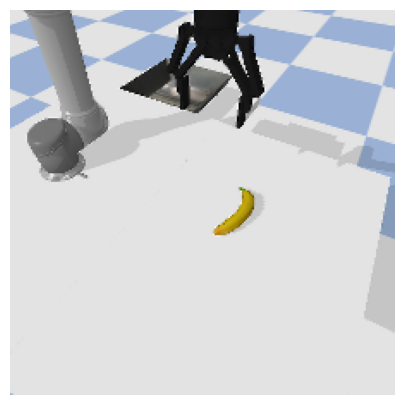

In [143]:
# you can use this shell to experiment with camera placement without having to reset simulation. After you find good config, you can copy paste to utilities.py
# def get_cfg():
#     _C1 = CN()
#     _C1.FOCUS_PT = [0.0, -0.52, 0.785]
#     _C1.YAW_ANGLES = [-60, 45, -45, 135]
#     _C1.DISTANCES = [0.75, 0.8, 0.8, 0.8]
#     _C1.PITCH_ANGLES = [-30, -25, -25, -25]
#     return _C1.clone()
# best so far
# def get_cfg():
#     _C1 = CN()
#     _C1.FOCUS_PT = [0.0, -0.52, 0.85]
#     _C1.YAW_ANGLES = [-60, 45, -45, 135]
#     _C1.DISTANCES = [0.75, 0.8, 0.8, 0.8]
#     _C1.PITCH_ANGLES = [-40, -35, -35, -35]
#     return _C1.clone()

# def get_cfg():
#     _C1 = CN()
#     _C1.FOCUS_PT = [0.05, -0.52, 0.85]
#     _C1.YAW_ANGLES = [-60, 45, -45, 135]
#     _C1.DISTANCES = [0.75, 0.8, 0.8, 0.8]
#     _C1.PITCH_ANGLES = [-45, -40, -40, -40]
#     return _C1.clone()

def get_cfg():
    _C1 = CN()
    _C1.FOCUS_PT = [0.05, -0.52, 0.85]
    _C1.YAW_ANGLES = [-60, 45, -45, 135]
    _C1.DISTANCES = [0.75, 0.8, 0.8, 0.8]
    _C1.PITCH_ANGLES = [-50, -45, -45, -45]
    return _C1.clone()
    
def render_tmp(env):
        
        def transform_image(image):
            h, w = image.shape[:2]
            # Center crop to 480x480
            start_x = w//2 - 240
            start_y = h//2 - 240
            image = image[start_y:start_y+480, start_x:start_x+480]
            #image = image[:,240:]
            # Resize to 224x224
            image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_LANCZOS4)
            return image

        camera = MultiCams(env.physicsClient, cfg=get_cfg(), n_cams=1)
        rgb, _ = camera.cams[0].get_images(get_rgb=True, get_depth=False, get_seg=False)
        rgb_transformed = transform_image(rgb)
        return rgb_transformed

img = render_tmp(env)
display_image(img, (5,5))

In [45]:
# def get_cfg():
#     _C1 = CN()
#     _C1.FOCUS_PT = [0.0, -0.52, 0.785]
#     _C1.YAW_ANGLES = [-60, 45, -45, 135]
#     _C1.DISTANCES = [0.75, 0.8, 0.8, 0.8]
#     _C1.PITCH_ANGLES = [-30, -25, -25, -25]
#     return _C1.clone()

# Slightly higher angle
# def get_cfg():
#     _C1 = CN()
#     _C1.FOCUS_PT = [0.0, -0.52, 0.85]
#     _C1.YAW_ANGLES = [-60, 45, -45, 135]
#     _C1.DISTANCES = [0.75, 0.8, 0.8, 0.8]
#     _C1.PITCH_ANGLES = [-35, -30, -30, -30]
#     return _C1.clone()

### Test `TrajectoryGenerator` without resetting the Crossformer model

In [144]:
# run this cell to re-import TrajectoryGenerator if you make code changes, without having to restart the notebook
import importlib
import trajectory_generator
importlib.reload(trajectory_generator)
from trajectory_generator import TrajectoryGenerator

In [145]:
generator = TrajectoryGenerator(model, task, get_cfg(), 224, 200, 5, make_video=True)

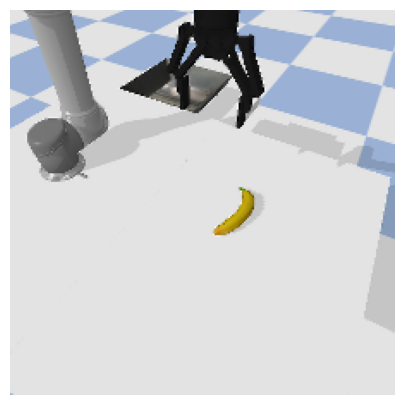

In [146]:
img = generator.render(env)
display_image(img, (5,5))

In [159]:
generator.predict_trajectory(env)

Action 1/4 in step 1/200.
Took delta action [ 3.1999956e-04  8.9880195e-04  7.2654808e-04 -7.0118387e-03
 -9.7636348e-03  1.3368128e-02  7.9414511e-01]


Action 2/4 in step 1/200.
Took delta action [-3.2318739e-04  2.8707169e-03 -1.9351395e-03 -8.1965448e-03
 -2.7127385e-03  2.3469467e-02  5.4436481e-01]


Action 3/4 in step 1/200.
Took delta action [-1.6508822e-03  4.6577100e-03 -2.7147979e-03 -7.9911081e-03
  1.3613654e-04  2.7913833e-02  1.0039229e+00]


Action 4/4 in step 1/200.
Took delta action [-3.1132170e-03  6.4618178e-03 -2.3986581e-03 -7.7192737e-03
 -3.5553804e-04  2.9396355e-02  1.0021975e+00]


Action 1/4 in step 2/200.
Took delta action [-0.00111975  0.00131292 -0.00194644 -0.00513959 -0.00415822  0.0127888
  0.99613965]


Action 2/4 in step 2/200.
Took delta action [-3.6756688e-04  1.3061796e-03 -1.9966071e-03 -4.2231786e-03
 -5.9002684e-04  1.2369447e-02  9.9990046e-01]


Action 3/4 in step 2/200.
Took delta action [-1.0537366e-04  1.8267732e-03 -2.2886344e-03 -4.00961

KeyboardInterrupt: 

In [1]:
p.disconnect()

NameError: name 'p' is not defined